<a href="https://colab.research.google.com/github/sgr1118/Kaggle-Transcription/blob/main/%5BFilb08%5DMercari_Price_Suggestion_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 구글 API 불러오기
!pip install kaggle
from google.colab import files
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rlfkr1234","key":"cf174d7e08b9e8738f8815cd6a5ad980"}'}

In [2]:
!ls -1ha kaggle.json
# kaggle json 파일 업로드 확인

kaggle.json


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning 방지
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c mercari-price-suggestion-challenge

 99% 401M/403M [00:09<00:00, 44.9MB/s]
100% 403M/403M [00:09<00:00, 44.5MB/s]


In [5]:
!ls

kaggle.json  mercari-price-suggestion-challenge.zip  sample_data


In [6]:
# 불러온 파일이 알집인 경우 
!unzip mercari-price-suggestion-challenge.zip

Archive:  mercari-price-suggestion-challenge.zip
  inflating: sample_submission.csv.7z  
  inflating: sample_submission_stg2.csv.zip  
  inflating: test.tsv.7z             
  inflating: test_stg2.tsv.zip       
  inflating: train.tsv.7z            


In [7]:
!pip install py7zr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 3.5 MB/s 
     |████████████████████████████████| 379 kB 73.7 MB/s 
     |████████████████████████████████| 357 kB 76.5 MB/s 
     |████████████████████████████████| 138 kB 61.4 MB/s 
     |████████████████████████████████| 92 kB 13.1 MB/s 
     |████████████████████████████████| 2.3 MB 68.6 MB/s 
     |████████████████████████████████| 50 kB 7.5 MB/s 


In [8]:
# unzip

import py7zr
file_name = ['train.tsv.7z', 'test.tsv.7z']
for name in file_name:
  with py7zr.SevenZipFile(name, mode='r') as z:
      z.extractall('/content')

In [9]:
# 라이브러리 불러오기
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split # sklearn 업데이트로 인하여 코드 변경

import matplotlib.pyplot as plt
%matplotlib inline 

import math

from subprocess import check_output
print(check_output(['ls', '/content']).decode("utf-8"))

kaggle.json
mercari-price-suggestion-challenge.zip
sample_data
sample_submission.csv.7z
sample_submission_stg2.csv.zip
test_stg2.tsv.zip
test.tsv
test.tsv.7z
train.tsv
train.tsv.7z



# RMSLE ()

![](https://velog.velcdn.com/images/addison/post/90cb00bc-cab4-4707-9ce3-514b2b4175ec/image.png)
<center>RMSLE 공식</center>

예측값과 실제값에 각각 로그를 취한 뒤 차이를 구한 다음 n만큼 나눠준 뒤 루트를 사용한다.




In [41]:
# 평가지표 함수 작성
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(to_sum) * (1.0/len(y))) ** 0.5

In [11]:
# 데이터 불러오기

train = pd.read_table('/content/train.tsv')
test = pd.read_table('/content/test.tsv')
print(train.shape)
print(test.shape)

(1482535, 8)
(693359, 7)


In [12]:
print(train.info(), test.info())

# object : category_name, brand_name, item_description
# 인코딩 후 결측치 여부를 확인하여 삭제 필요

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693359 entries, 0 to 693358
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   test_id            693359 non-null  int64 
 1   name               693359 non-null  object
 2   item_condition_id 

In [13]:
# 결측치 처리하기
# 결측값은 전부 'missing'으로 처리한다.

def handle_missing(dataset):
  dataset.category_name.fillna(value = 'missing', inplace = True)
  dataset.brand_name.fillna(value = 'missing', inplace = True)
  dataset.item_description.fillna(value = 'missing', inplace = True)
  return (dataset)

train = handle_missing(train)
test = handle_missing(test)


In [14]:
# train 데이터 일부 확인
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,missing,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,missing,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,missing,44.0,0,Complete with certificate of authenticity


In [15]:
# object형 데이터 인코더 적용
# object : category_name, brand_name, item_description

le = LabelEncoder()

le.fit(np.hstack([train.category_name, test.category_name]))
train.category_name = le.transform(train.category_name)
test.category_name = le.transform(test.category_name)

le.fit(np.hstack([train.brand_name, test.brand_name]))
train.brand_name = le.transform(train.brand_name)
test.brand_name = le.transform(test.brand_name)
del le

train.head(3)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,829,5265,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,86,3889,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,1277,4588,10.0,1,Adorable top with a hint of lace and a key hol...


In [16]:
# 토크나이저 적용

from keras.preprocessing.text import Tokenizer

raw_text = np.hstack([train.item_description.str.lower(), train.name.str.lower()])

tok_raw = Tokenizer()
tok_raw.fit_on_texts(raw_text)

train['seq_item_description'] = tok_raw.texts_to_sequences(train.item_description.str.lower())
test["seq_item_description"] = tok_raw.texts_to_sequences(test.item_description.str.lower())
train["seq_name"] = tok_raw.texts_to_sequences(train.name.str.lower())
test["seq_name"] = tok_raw.texts_to_sequences(test.name.str.lower())
train.head(3)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,seq_item_description,seq_name
0,0,MLB Cincinnati Reds T Shirt Size XL,3,829,5265,10.0,1,No description yet,"[12, 68, 79]","[3852, 8823, 6896, 208, 84, 6, 155]"
1,1,Razer BlackWidow Chroma Keyboard,3,86,3889,52.0,0,This keyboard is in great condition and works ...,"[29, 2627, 10, 7, 39, 17, 1, 207, 51, 19, 1113...","[10760, 25565, 16369, 2627]"
2,2,AVA-VIV Blouse,1,1277,4588,10.0,1,Adorable top with a hint of lace and a key hol...,"[604, 60, 9, 4, 5347, 11, 192, 1, 4, 886, 1290...","[7634, 10563, 666]"


In [17]:
# SEQUENCES VARIABLES ANALYSIS

max_name_seq = np.max([np.max(train.seq_name.apply(lambda x: len(x))), 
                       np.max(test.seq_name.apply(lambda x: len(x)))])
max_seq_item_description = np.max([np.max(train.seq_item_description.apply(lambda x: len(x)))
                                   , np.max(test.seq_item_description.apply(lambda x: len(x)))])
print("max name seq "+str(max_name_seq))
print("max item desc seq "+str(max_seq_item_description))

max name seq 17
max item desc seq 269


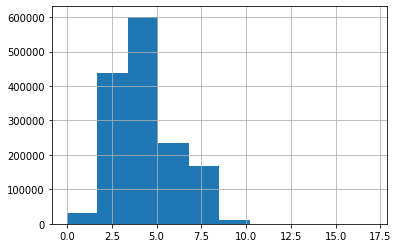

In [18]:
# seq_name 시각화

train.seq_name.apply(lambda x: len(x)).hist()

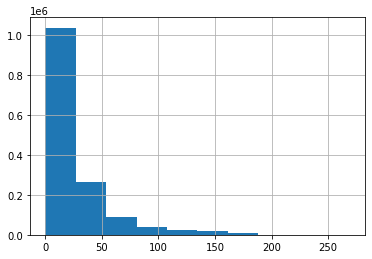

In [19]:
train.seq_item_description.apply(lambda x: len(x)).hist()

In [20]:
# max value 지정

MAX_NAME_SEQ = 10
MAX_ITEM_DESC_SEQ = 75
MAX_TEXT = np.max([np.max(train.seq_name.max()),
                   np.max(test.seq_name.max()),
                   np.max(train.seq_item_description.max()),
                   np.max(test.seq_item_description.max())])+2

MAX_CATEGORY = np.max([train.category_name.max(), test.category_name.max()])+1
MAX_BRAND = np.max([train.brand_name.max(), test.brand_name.max()])+1
MAX_CONDITION = np.max([train.item_condition_id.max(), test.item_condition_id.max()])+1

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa3810b8dd0>]],
      dtype=object)

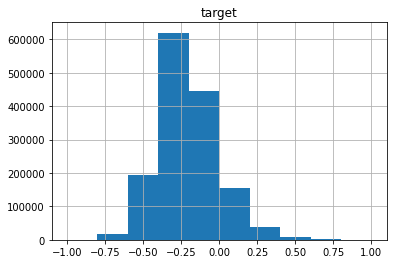

In [21]:
# 타겟 변수 스케일링

train["target"] = np.log(train.price+1)
target_scaler = MinMaxScaler(feature_range=(-1, 1))
# train["target"] = target_scaler.fit_transform(train.target.reshape(-1, 1)) # 버전 0.19.0부터 폐지: 이 메서드를 호출하면 오류가 발생합니다.
train["target"] = target_scaler.fit_transform(train.target.values.reshape(-1, 1))

pd.DataFrame(train.target).hist()

In [22]:
# EXTRACT DEVELOPTMENT TEST

dtrain, dvalid = train_test_split(train, random_state=123, train_size=0.99)
print(dtrain.shape)
print(dvalid.shape)

(1467709, 11)
(14826, 11)


In [38]:
# 케라스 데이터 정의
# tf 2.9 버젼에서는 아래와같이 작성해야한다.
from tensorflow.keras.preprocessing.sequence import pad_sequences

def get_keras_data(dataset):
  X = {'name' : pad_sequences(dataset.seq_name, maxlen = MAX_NAME_SEQ),
       'item_desc' : pad_sequences(dataset.seq_item_description, maxlen = MAX_ITEM_DESC_SEQ),
       'brand_name': np.array(dataset.brand_name),
       'category_name': np.array(dataset.category_name),
       'item_condition': np.array(dataset.item_condition_id),
       'num_vars': np.array(dataset[["shipping"]])}
  return X

X_train = get_keras_data(dtrain)
X_valid = get_keras_data(dvalid)
X_test = get_keras_data(test)

In [42]:
# 케라스 모델 정의

from keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU, Embedding, Flatten, BatchNormalization
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras import backend as K

def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

def rmsle_cust(y_true, y_pred):
    first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
    second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
    return K.sqrt(K.mean(K.square(first_log - second_log), axis=-1))

def get_model():
  # params
  dr_r = 0.1

  # Input
  name = Input(shape = [X_train['name'].shape[1]], name = 'name')
  item_desc = Input(shape=[X_train["item_desc"].shape[1]], name="item_desc")
  brand_name = Input(shape=[1], name="brand_name")
  category_name = Input(shape=[1], name="category_name")
  item_condition = Input(shape=[1], name="item_condition")
  num_vars = Input(shape=[X_train["num_vars"].shape[1]], name="num_vars")

  # Embeddings layers
  emb_name = Embedding(MAX_TEXT, 50)(name)
  emb_item_desc = Embedding(MAX_TEXT, 50)(item_desc)
  emb_brand_name = Embedding(MAX_BRAND, 10)(brand_name)
  emb_category_name = Embedding(MAX_CATEGORY, 10)(category_name)
  emb_item_condition = Embedding(MAX_CONDITION, 5)(item_condition)

  # rnn layer
  rnn_layer1 = GRU(16) (emb_item_desc)
  rnn_layer2 = GRU(8) (emb_name)

  # main layer
  main_l = concatenate([Flatten() (emb_brand_name),
                        Flatten() (emb_category_name),
                        Flatten() (emb_item_condition),
                        rnn_layer1,
                        rnn_layer2,
                        num_vars])
  
  main_l = Dropout(dr_r) (Dense(128) (main_l))
  main_l = Dropout(dr_r) (Dense(64) (main_l))

  # output
  output = Dense(1, activation = 'linear') (main_l)

  # model
  model = Model([name, item_desc, brand_name, 
                 category_name, item_condition, num_vars], output)
  model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mse', rmsle_cust])

  return model

In [35]:
# 모델 학습

model = get_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 brand_name (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 category_name (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 item_condition (InputLayer)    [(None, 1)]          0           []                               
                                                                                                  
 item_desc (InputLayer)         [(None, 75)]         0           []                               
                                                                                              

In [39]:
# 모델 fit

BATCH_SIZE = 20000
epochs = 5

model = get_model()
model.fit(X_train, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
          , validation_data=(X_valid, dvalid.target)
          , verbose=1)

Epoch 1/5
74/74 [==============================] - 16s 109ms/step - loss: 0.0276 - mse: 0.0276 - rmsle_cust: 0.0153 - val_loss: 0.0180 - val_mse: 0.0180 - val_rmsle_cust: 0.0134
Epoch 2/5
74/74 [==============================] - 7s 99ms/step - loss: 0.0179 - mse: 0.0179 - rmsle_cust: 0.0132 - val_loss: 0.0161 - val_mse: 0.0161 - val_rmsle_cust: 0.0127
Epoch 3/5
74/74 [==============================] - 7s 99ms/step - loss: 0.0158 - mse: 0.0158 - rmsle_cust: 0.0125 - val_loss: 0.0155 - val_mse: 0.0155 - val_rmsle_cust: 0.0124
Epoch 4/5
74/74 [==============================] - 7s 99ms/step - loss: 0.0147 - mse: 0.0147 - rmsle_cust: 0.0121 - val_loss: 0.0152 - val_mse: 0.0152 - val_rmsle_cust: 0.0123
Epoch 5/5
74/74 [==============================] - 7s 100ms/step - loss: 0.0141 - mse: 0.0141 - rmsle_cust: 0.0119 - val_loss: 0.0153 - val_mse: 0.0153 - val_rmsle_cust: 0.0123


In [43]:
# 모델 테스트
val_preds = model.predict(X_valid)
val_preds = target_scaler.inverse_transform(val_preds)
val_preds = np.exp(val_preds)+1

#mean_absolute_error, mean_squared_log_error
y_true = np.array(dvalid.price.values)
y_pred = val_preds[:,0]
v_rmsle = rmsle(y_true, y_pred)
print(" RMSLE error on dev test: "+str(v_rmsle))

464/464 [==============================] - 2s 3ms/step
 RMSLE error on dev test: 0.48915077954665587


In [44]:
# 예측 결과 생성

preds = model.predict(X_test, batch_size=BATCH_SIZE)
preds = target_scaler.inverse_transform(preds)
preds = np.exp(preds)-1

submission = test[["test_id"]]
submission["price"] = preds

35/35 [==============================] - 1s 23ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


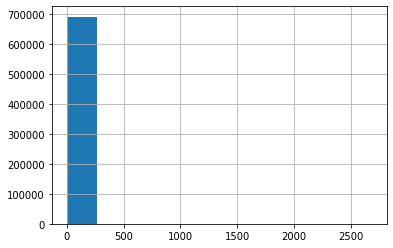

In [45]:
submission.to_csv("./myNNsubmission.csv", index=False)
submission.price.hist()